# Tutorial 1: The (Not So) Short Introduction to EasyTS

**Author:** Hannu Parviainen <br>
**Edited:** 22 August 2024

This notebook gives a rather verbose introduction to transmission spectroscopy with EasyTS and shows how to reproduce a low-resolution version of the transmission spectroscopy analysis of WASP-39b observed with JWST NIRISS by [Feinstein et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023Natur.614..670F/abstract). Later notebooks show how to use the LDTk-based limb darkening model and what happens when we increase the resolution.

**Note:** If you're looking for a template to start your own analysis with, the [The (Very) Short Introduction to EasyTS](01b_short_intro.ipynb) notebook reproduces this one in a less verbose format.

We start by forcing different multithreaded codes to use a single thread. This is important when parallelising the computations with multiprocessing since it would be very easy to end up with a number of processes all trying to use all the computer's cores. After this, we initialise Matplotlib and import some standard packages and functions.

In [1]:
%run ../setup_multiprocessing.py

In [2]:
%matplotlib inline

In [3]:
from multiprocessing import Pool
from xarray import load_dataset
from scipy.interpolate import splev, splrep
from numpy import array, geomspace, linspace
from matplotlib.pyplot import subplots, setp

from easyts import EasyTS, TSData

## Data preparation
### Read in the data

We read the spectroscopic light curves and store them as `easyts.TSData` objects. `TSData` is an utility class to store and manipulate  spectroscopic time series before using them in a transmission spectrum analysis.

**None:** [appendix 1](appendix_1_data_preparation.ipynb) notebook shows how the original [Feinstein et al (2023)](https://ui.adsabs.harvard.edu/abs/2023Natur.614..670F/abstract) light curves downloaded from Zotero are converted into a simple xarray dataset.

We first define a simple utility function to read the xarray DataSet into `TSData` and then read the order 1 light curves. We remove any strong individual outlier points, and plot the data.

In [4]:
def read_data(fname):
    with load_dataset(fname) as ds:
        return TSData(time=ds.time.values, wavelength=ds.wavelength.values, fluxes=ds.flux.values, errors=ds.error.values)

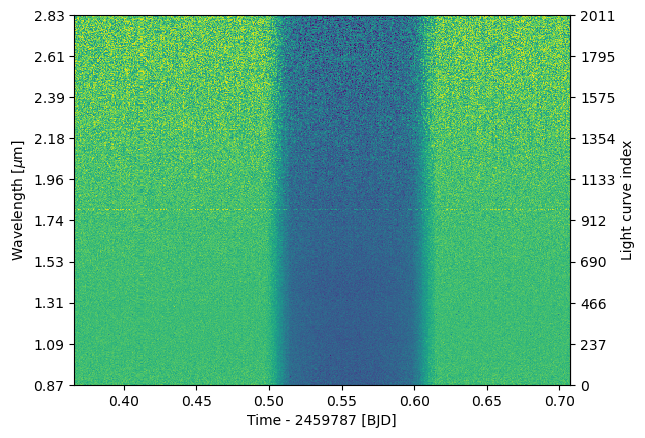

In [5]:
d1 = read_data('data/nirHiss_order_1.h5')
d1.remove_outliers()
d1.plot();

Next, we read order 2 light curves, crop the spectral range not to overlap with order 1, and again remove any strong outliers.

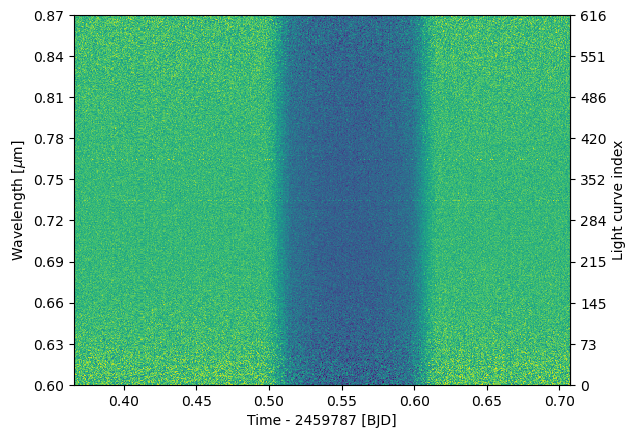

In [6]:
d2 = read_data('data/nirHiss_order_2.h5')
d2.crop_wavelength(0.6, d1.wllims[0])
d2.remove_outliers()
d2.plot();

### Finalize the dataset

Finally, we bin the spectroscopic light curves to R=100 (we are doing a low-resolution analysis in this notebook anyway) and combine the two orders into a single `TSData` object. Now, we end up with a data set consisting of 155 light curves covering the wavelength range from 0.6 to 2.83 $\mu$m. 

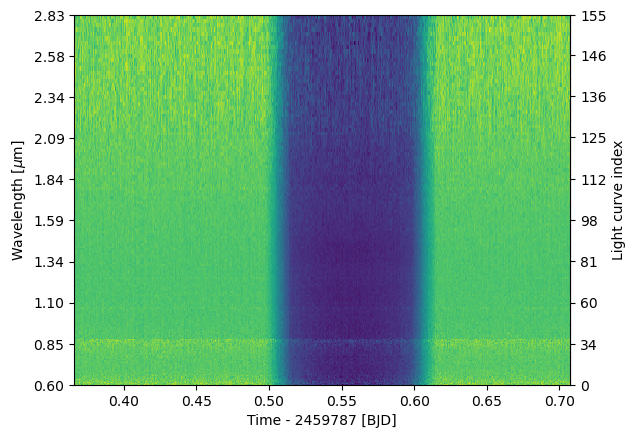

In [7]:
db = d2.bin_wavelength(r = 100) + d1.bin_wavelength(r = 100)
ax = db.plot()

## Transmission spectroscopy
### Initialize EasyTS and set the priors

Now, we're ready start the real work! We initialise the `EasyTS` class by giving it 

- `name`: a name for the analysis. This will be used in automatic savefiles.
- `ldmodel`: a limb darkening model. This can be any limb darkening model accepted by PyTransit's `RoadRunnerModel`.
- `data`: a `TSData` object containing the data.
- `nk`: number of radius ratio knots. This sets the final transmission spectrum resolution.
- `nldc`: number of limb darkening knots.
- `nthreads`: number of threads used in the model calculation. We set this to one because we use multiprocessing to parallelise the computations.

In [8]:
ts = EasyTS('01a_lowres_power2', ldmodel='power-2', data=db, nk=50, nldc=10, nthreads=1)

We can take a look at the transmission spectum model parameterization using `EasyTS.ps`, where `ps` stands for "parameter set". Let's print the first 10 parameters (feel free to print them all to see the full parameterization).

In [9]:
ts.ps[:10]

[  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   1 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   2 |G| p              N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   4 |G| secw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   5 |G| sesw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   6 |G| ldc1_00.60334  U(a = 0, b = 1)                          [    -inf ..      inf],
   7 |G| ldc2_00.60334  U(a = 0, b = 1)                          [    -inf ..      inf],
   8 |G| ldc1_00.84981  U(a = 0, b = 1)                          [    -inf ..      inf],
   9 |G| ldc2_00.84981  U(a = 0, b = 1)                          [    -inf ..      inf]]

The parameters are ordered in blocks: [[orbit] [limb darkening] [radius ratio] [baseline]], where the orbit is always defined by the first 6 parameters, the number of limb darkening parameters depends on the limb darkening model and number of limb darkening knots, and the number of radius ratios depends on the number of radius ratio knots.

The parameters defining the orbit are:
 - rho: stellar density [g/cm$^3$]
 - tc: transit center
 - p: orbital period [d]
 - b: impact parameter
 - secw: $\sqrt e \cos \omega$, where $e$ is the eccentricity and $\omega$ is the argument of periastron in radians, set to 0 by default
 - sesw: $\sqrt e \sin \omega$, where $e$ is the eccentricity and $\omega$ is the argument of periastron in radians, set to 0 by default

The first thing we need to do at the beginning of the analysis is to set priors for the transit center (`tc`) and orbital period (`p`). The stellar density (`rho`) and the impact parameter (`b`) are usually constrained well by our photometry, so we can leave the default uninformative priors. 

We set the priors using the `EasyTS.set_prior` method that takes the parameter name as its first argument, the prior as its second argument, and the prior parameters as optional additional arguments. The prior can be any object with `logpdf(x)` and `rvs(n)` methods, where `x` should be allowed to be either a scalar or an array and `n` an integer, but you can also use shortcut strings for normal priors (`NP`) and uniform priors (`UP`).

In [10]:
ts.set_prior('tc', 'NP', 2459694.286, 0.003)
ts.set_prior('p', 'NP', 4.05487, 1e-5)

In [11]:
ts.ps[:10]

[  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   1 |G| tc             N(μ = 2459694.286, σ = 0.003)            [    -inf ..      inf],
   2 |G| p              N(μ = 4.05487, σ = 1e-05)                [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   4 |G| secw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   5 |G| sesw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   6 |G| ldc1_00.60334  U(a = 0, b = 1)                          [    -inf ..      inf],
   7 |G| ldc2_00.60334  U(a = 0, b = 1)                          [    -inf ..      inf],
   8 |G| ldc1_00.84981  U(a = 0, b = 1)                          [    -inf ..      inf],
   9 |G| ldc2_00.84981  U(a = 0, b = 1)                          [    -inf ..      inf]]

Next, we can set a slightly less uninformative priors on the radius ratios by using the `EasyTS.set_radius_ratio_prior` method. Let's take a look at the first four radius ratio parameters

In [12]:
ts.ps[24:30]

[ 24 |G| ldc1_02.82154  U(a = 0, b = 1)                          [    -inf ..      inf],
  25 |G| ldc2_02.82154  U(a = 0, b = 1)                          [    -inf ..      inf],
  26 |G| k_00.60334     U(a = 0.02, b = 0.2)                     [    0.00 ..      inf],
  27 |G| k_00.64861     U(a = 0.02, b = 0.2)                     [    0.00 ..      inf],
  28 |G| k_00.69388     U(a = 0.02, b = 0.2)                     [    0.00 ..      inf],
  29 |G| k_00.73915     U(a = 0.02, b = 0.2)                     [    0.00 ..      inf]]

In [13]:
ts.set_radius_ratio_prior('UP', 0.14, 0.15)

In [14]:
ts.ps[24:30]

[ 24 |G| ldc1_02.82154  U(a = 0, b = 1)                          [    -inf ..      inf],
  25 |G| ldc2_02.82154  U(a = 0, b = 1)                          [    -inf ..      inf],
  26 |G| k_00.60334     U(a = 0.14, b = 0.15)                    [    0.00 ..      inf],
  27 |G| k_00.64861     U(a = 0.14, b = 0.15)                    [    0.00 ..      inf],
  28 |G| k_00.69388     U(a = 0.14, b = 0.15)                    [    0.00 ..      inf],
  29 |G| k_00.73915     U(a = 0.14, b = 0.15)                    [    0.00 ..      inf]]

### Set the limb darkening priors

This example uses the power-2 limb darkening model with two limb darkening coefficients per limb darkening knot. Calling `EasyTS.set_ldtk_priors` calculates the priors for the limb darkening coefficients using `LDTk` automatically. 

Let's first take a look at the limb darkening coefficient priors for the first two knots before we set the priors:

In [15]:
ts.ps[6:10]

[  6 |G| ldc1_00.60334  U(a = 0, b = 1)                          [    -inf ..      inf],
   7 |G| ldc2_00.60334  U(a = 0, b = 1)                          [    -inf ..      inf],
   8 |G| ldc1_00.84981  U(a = 0, b = 1)                          [    -inf ..      inf],
   9 |G| ldc2_00.84981  U(a = 0, b = 1)                          [    -inf ..      inf]]

The default prior for the coeffients is a uniform distribution from 0 to 1. Then, lets let's use `LDTk` to calculate the priors

In [16]:
ts.set_ldtk_prior(teff=(5327, 139), logg=(4.38, 0.09), metal=(-0.01, 0.1), uncertainty_multiplier=10)

And let's look at the priors now

In [17]:
ts.ps[6:10]

[  6 |G| ldc1_00.60334  N(μ = 0.734, σ = 0.019)                  [    -inf ..      inf],
   7 |G| ldc2_00.60334  N(μ = 0.813, σ = 0.034)                  [    -inf ..      inf],
   8 |G| ldc1_00.84981  N(μ = 0.596, σ = 0.016)                  [    -inf ..      inf],
   9 |G| ldc2_00.84981  N(μ = 0.697, σ = 0.027)                  [    -inf ..      inf]]

The `uncertainty_multiplier` parameter inflates the prior uncertainties. This ensures that we err on the cautious side when it comes to how much we trust the stellar models on which the limb darkening coefficient priors are based.

### Customise the radius ratio knot locations

`EasyTS` represents the planet-to-star radius ratio and the limb darkening parameters as cubic interpolating B-splines defined by $N$  points (knots). The wavelength locations of the knots are defined at the start of the analysis (although both the number of knots and knot positions can be modified later), and the knot values are added to the model as free parameters. *The spectroscopic transit model is always computed for all wavelength bins in the data, but the number of wavelength bins and the number of radius ratio knots does not need to be the same.*

This approach ensures that we can freely optimise the resolution of the transmission spectrum to our science case. For example, we can increase the knot density near strong absorption lines and use a smaller density in areas where we don't expect any sharp features.

The resolution of the transmission spectrum estimated by `EasyTS` is defined mainly by two factors: 
1. the wavelength resolution of the data, and
2. the number and location of the radius ratio knots.

The wavelength resolution of the spectroscopic light curves sets the upper limit for the resolution.

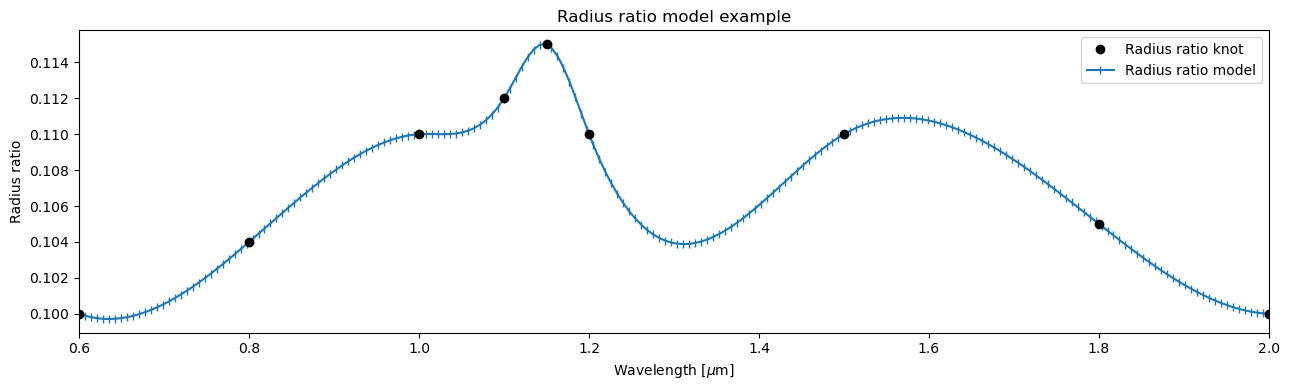

In [18]:
fig, ax = subplots(figsize=(13,4))
l = array([0.6, 0.8, 1.00,   1.1, 1.15,   1.2,  1.5, 1.8, 2.0])
k = array([0.1, 0.104, 0.11, 0.112, 0.115, 0.11, 0.11, 0.105, 0.1])
x = linspace(l[0], l[-1], 200)
ax.plot(l, k, 'ko', label='Radius ratio knot', zorder=2)
ax.plot(x, splev(x, splrep(l, k, s=0.0)), '|-', label='Radius ratio model', zorder=1)
ax.legend()
setp(ax, ylabel='Radius ratio', xlabel=r'Wavelength [$\mu$m]', xlim=l[[0,-1]], title='Radius ratio model example')
fig.tight_layout()

`EasyTS` uses linear spacing between the radius ratio knots by default. The knot locations for the limb darkening parameters and radius ratios can be visualised using the `EasyTS.plot_setup` method.

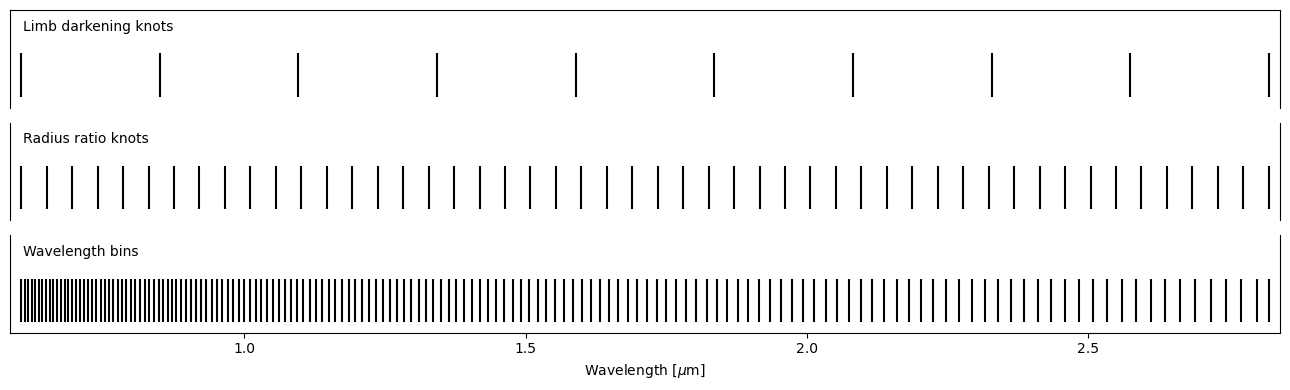

In [19]:
ts.plot_setup();

 Let's change to use a uniform spacing in log-wavelength (geomspace) and add some extra knots to cover the K line. First, we use `EasyTS.set_k_knots` to replace the old knots with the new ones, and then we use `EasyTS.add_k_knots` to add five knots to the existing ones. This changes our number of radius ratio knots (`nk`) from 50 to 55, and forces `EasyTS` to change the model parametrisation. The priors for the unaffected parameters are copied, but the new radius ratio knots now have default priors, so we need to set the radius ratio prior again. 

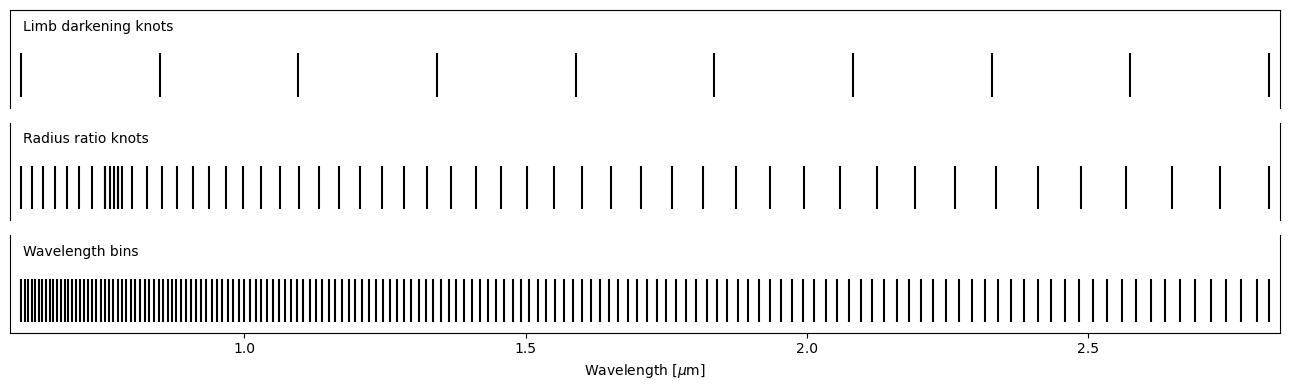

In [20]:
ts.set_radius_ratio_knots(geomspace(*ts.wavelength[[0, -1]], 50))
ts.add_radius_ratio_knots(linspace(0.768-0.015, 0.768+0.015, 5))
ts.set_radius_ratio_prior('UP', 0.14, 0.15)
ts.plot_setup();

### Fit the white light curve

Our first fitting step is to fit the white light curve. This is done mainly to obtain accurate estimates for the transit start and end times (T$_1$ and T$_4$) for the baseline normalisation, but it can also give useful insight into whether everything is ok with our data.

In [21]:
ts.fit_white()

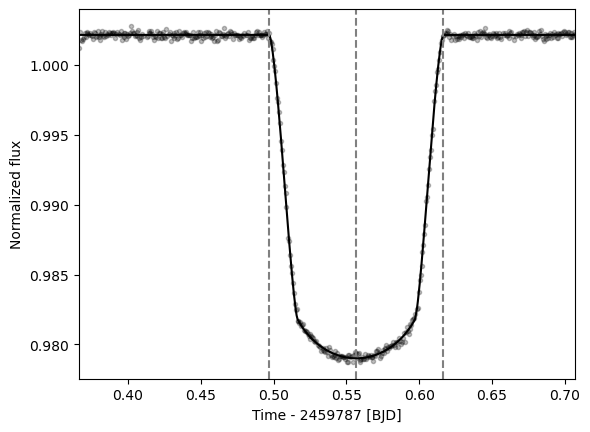

In [22]:
ax = ts.plot_white()

### Normalise the baseline

The next step is to normalise every spectroscopic light curve by dividing it with a line fitted to the light curve's out-of-transit (oot) flux. The outcome of the normalisation can be visualised with the `EasyTS.plot_baseline` method.

**Note:** `EasyTS` does not allow you to use a polynomial with a degree highter than 1 for normalisation because the curvature could (would) affect the transit depths.

In [23]:
ts.normalize_baseline(1)

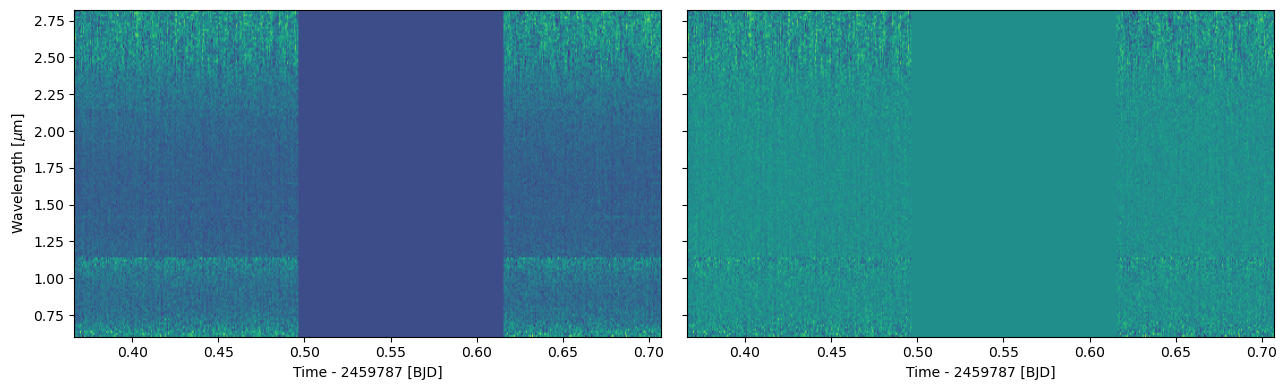

In [24]:
ts.plot_baseline();

### Save the model

We can already save the model for the first time using the `EasyTS.save` method. This saves the data and the model setup (including the priors) into a fits file that can be later used to recreate the model using the `read_model` function. We will also call this after the model optimisation and posterior sampling, where the method also saves the optimisation information and the MCMC samples into the fits file.

In [25]:
ts.save(overwrite=True)

### Set up multiprocessing

Now we're almost ready for fitting and MCMC sampling, but since we're using multiprocessing to parallelise the process, we first need to take some extra steps to make sure everything works the way it's supposed to.

First, we need to define a log-posterior function that calls the `EasyTS` log-posterior method. This must be done so that Python can pickle the method for parallelisation (if you know a better way, please let me know). Next, we also create a multiprocessing pool that will be used by the global optimiser and the MCMC sampler.

In [26]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

### Fit the transmission spectrum

We start the analysis by fitting the model with the `EasyTS.fit` method that uses a differential evolution (DE) global optimiser to find the log-posterior mode. The optimiser creates a parameter population of `npop` parameter vectors and iterates it over `niter` iterations, where the parameter vector population is clumped closer to the global posterior mode every iteration. The number of iterations and the size of the population depends on the number of radius ratio and limb darkening knots, but we can start with a small number of iterations to see how the minimisation works.

Global optimisation:   0%|          | 0/25 [00:00<?, ?it/s]

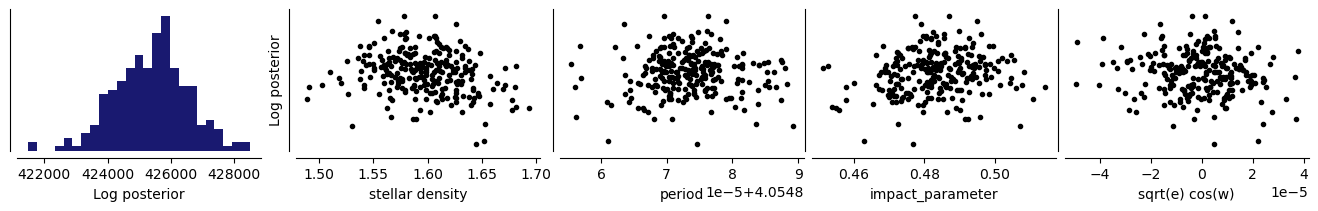

In [27]:
ts.fit(niter=25, npop=250, pool=pool, lnpost=lnpostf)

The resulting plot shows the distribution of log posterior values for the last parameter vector population, as well as the joint distributions for the log posterior and four model parameters. The fitting should be continued until the log posterior distribution has a width of < 1.

Let's plot the residuals, transmission spectrum, and the limb darkening parameters corresponding to the best-fitting solution.

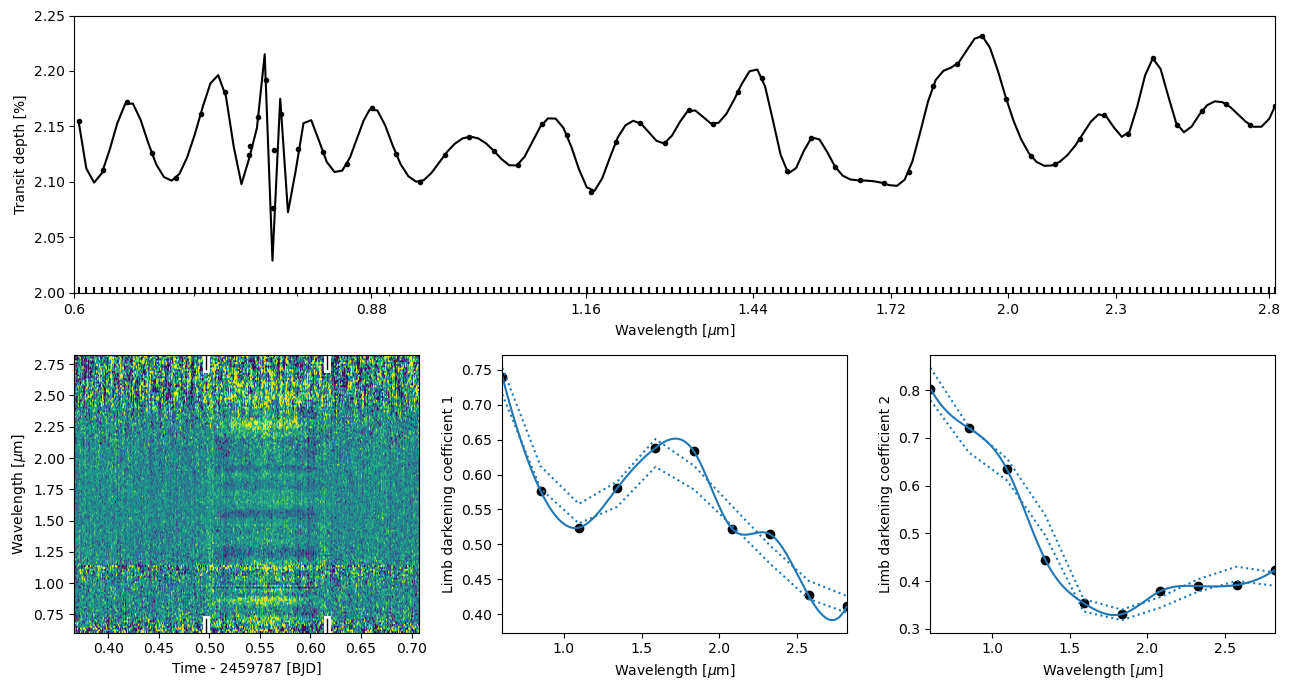

In [28]:
ts.plot_fit(result='fit', figsize=(13,7), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]))

We can immediately see from the residual plot that the current best-fit solution is bad. This is something we could have guessed already by looking at the log posterior distribution in the optimiser plot that shows a spread of tens of thousands. Let's continue the fitting for another 25 iterations. Each successive `EasyTS.fit` call continues optimisation from the solution of the previous call, and it also plots the old and new posterior and parameter populations at the end of the fit to visualise how the population is changing.

In [29]:
ts._tsa.de.min_ptp = 2

So, it is clear at this stage that running the optimiser for 25 iterations is not doing much. Let's continue the optimisation for 5000 iterations and see if this does the trick. This should take 2-3 min (or less if you initialise the pool with more processes) and the optimisation should finish before it reaches 5000 iterations (the progress bar turns red).

Global optimisation:   0%|          | 0/5000 [00:00<?, ?it/s]

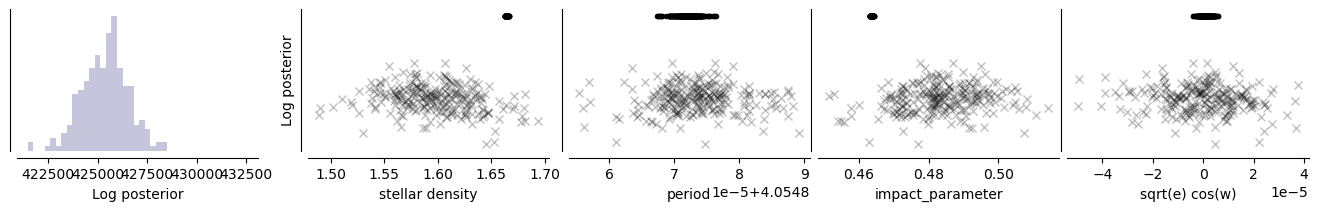

In [30]:
ts.fit(niter=5000, npop=250, pool=pool, lnpost=lnpostf)

Let's plot everything once again. This time, the residuals look good (there's no trace of a transit signal there), the transmission spectrum looks something else than just noise, and the limb darkening parameters also look good, so we're ready to move to the final step: the MCMC sampling.

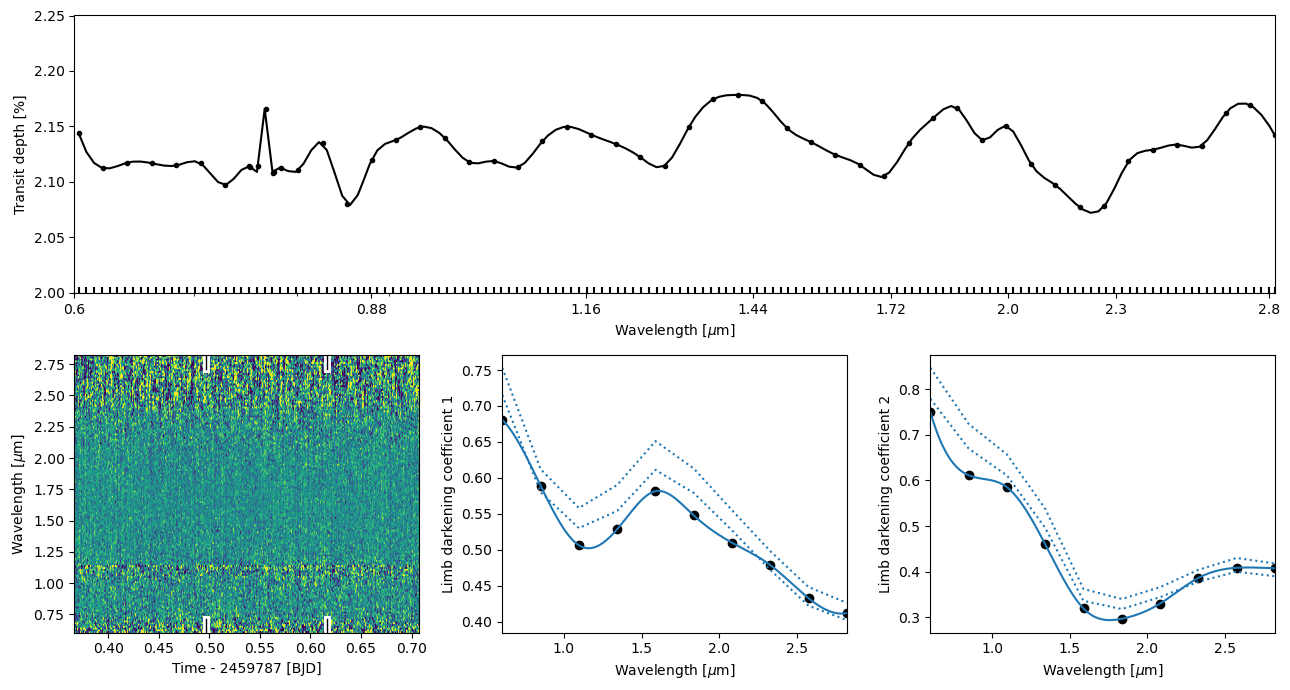

In [32]:
ts.plot_fit(result='fit', figsize=(13,7), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]))

### Save the optimisation results

In [33]:
ts.save(overwrite=True)

### MCMC sampling

Next comes the final part, obtaining a posterior sample using Markov Chain Monte Carlo (MCMC) sampling. This is done using the `EasyTS.sample` method, that starts with the parameter vector population from the global optimisation. 

As a first step, let's still inflate the limb darkening parameter prior widths by ten to make sure we're not constraining them too much in the sampling phase. So, now we set `uncertainty_multiplier=100` instead of `uncertainty_multiplier=10` that we used in fitting.

In [35]:
ts.sample(1000, thin=100, repeats=3, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/1000 [00:00<?, ?it/s]

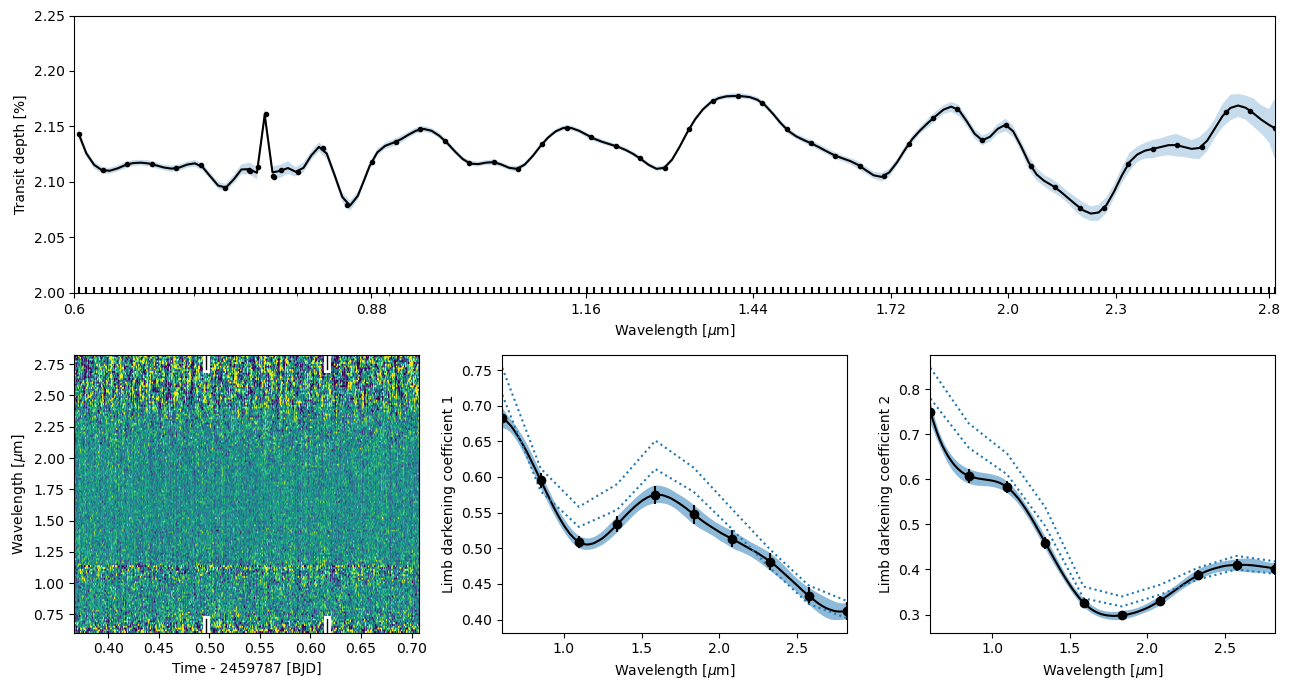

In [36]:
ts.plot_fit(result='mcmc', figsize=(13,7), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]))

### Save the results and export the transmission spectrum

Congratulations, you now have a low-resolution transmission spectrum for your observations! Let's save the model one more time to also store the posterior samples inside the fits file.

In [37]:
ts.save(overwrite=True)

In [38]:
ts.get_transmission_spectrum()

,depth,depth_e,depth_eneg,depth_epos
wavelength,,,,
0.603338,0.021437,0.000043,-0.000044,0.000042
0.609402,0.021258,0.000029,-0.000028,0.000029
0.615527,0.021155,0.000031,-0.000033,0.000029
0.621713,0.021107,0.000029,-0.000030,0.000028
0.627961,0.021101,0.000027,-0.000027,0.000026
...,...,...,...,...
2.718132,0.021668,0.000110,-0.000109,0.000111
2.745450,0.021617,0.000128,-0.000121,0.000135
2.773042,0.021560,0.000127,-0.000125,0.000130


---

<center>&copy;2024 Hannu Parviainen</center>